# Anomaly detection

In [1]:
from detector import *

In [2]:
# loading cars
cars = pd.read_csv("CQA_Premium.csv")\
          [['model_length_mm', 'model_width_mm']]\
          .rename(columns={
            'model_length_mm': 'length',
            'model_width_mm': 'width'
          })
cars.is_copy = False

cars.loc[:, 'class'] = "car"
print('cars shape:\t{0}'.format(cars.shape))

cars shape:	(70847, 3)


In [3]:
# loading pedestrians
body = pd.read_csv("body.csv", sep=';')\
       [['shoulder.girth', 'height']]\
       .rename(columns={
           'shoulder.girth': 'width',
           'height': 'length'
       })
        
# converting cm to mm
body['width'] = body['width'].map(lambda x: 10 * float(x.replace(',', '.')))
body['length'] = body['length'].map(lambda x: 10 * float(x.replace(',', '.')))

body.is_copy = False
body.loc[:, 'class'] = "human"
print('body shape:\t{0}'.format(body.shape))

body shape:	(507, 3)


In [4]:
detector = Detector(cars[cars['width'] < 3000].append(body))

loaded 5520 rows (0.04 s)


using seed: 373912359


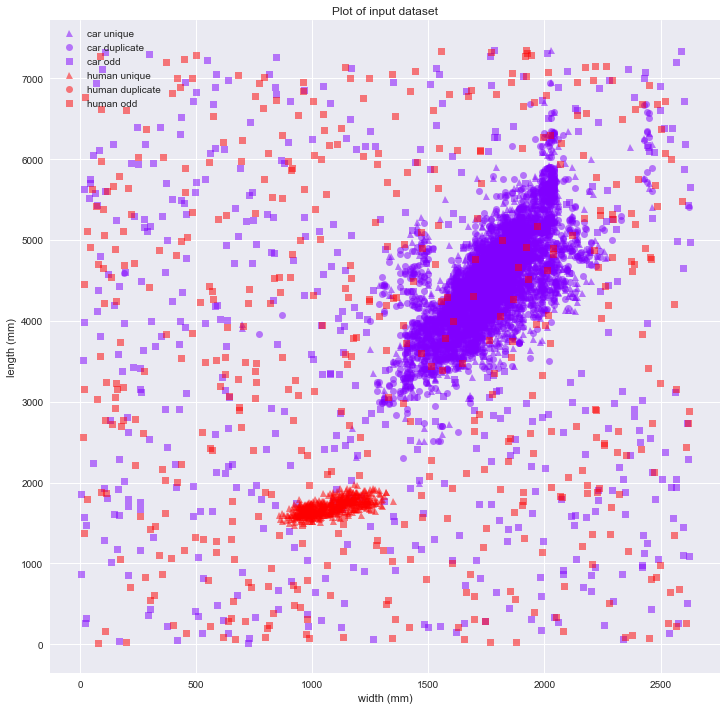

In [5]:
minx, maxx = 0, max(detector.df['width']) + 1
miny, maxy = 0, max(detector.df['length']) + 1
n = 1000
tmp = []
for k in range(n):
    tmp.append([rd.choice(['car', 'human']),
                rd.randint(miny, maxy),
                rd.randint(minx, maxx)])
detector.append_odd_points(tmp)
detector.format()
detector.plot()

In [6]:
from sklearn import svm
from sklearn import ensemble
from sklearn import neural_network

classifiers = [
    neural_network.MLPClassifier(hidden_layer_sizes=(30,30,30)),
    ensemble.AdaBoostClassifier(n_estimators=15, learning_rate=1),
    svm.SVC(kernel='linear'),
    ensemble.RandomForestClassifier()
]

titles = (
    'perceptron   ',
    'adaboost     ',
    'svm          ',
    'random forest'
)

results = {}
for clf, title in zip(classifiers, titles):
    results[title] = confusion_ratios(detector.classify(clf)[0])

for _ in range(len(titles[0])):
    print(' ', end='')
print('\tTPR\tFPR\tTNR\tFNR')
for title in results.keys():
    print("{0}\t".format(title), end='')
    for x in results[title]:
        print('{0}\t'.format(round(x, 4)), end='')
    print()
    

             	TPR	FPR	TNR	FNR
perceptron   	0.6625	0.0248	0.9752	0.3375	
adaboost     	0.6939	0.0101	0.9899	0.3061	
svm          	0.2055	0.0481	0.9519	0.7945	
random forest	0.8868	0.0054	0.9946	0.1132	


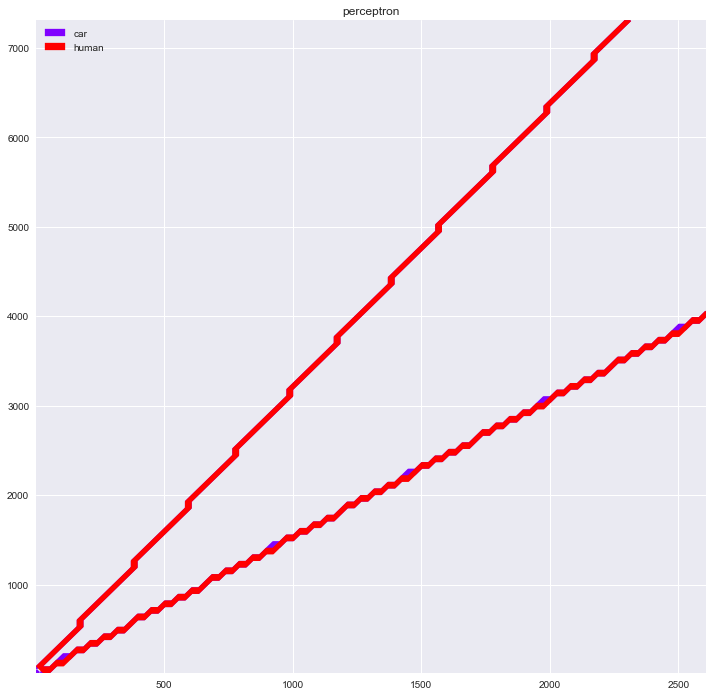

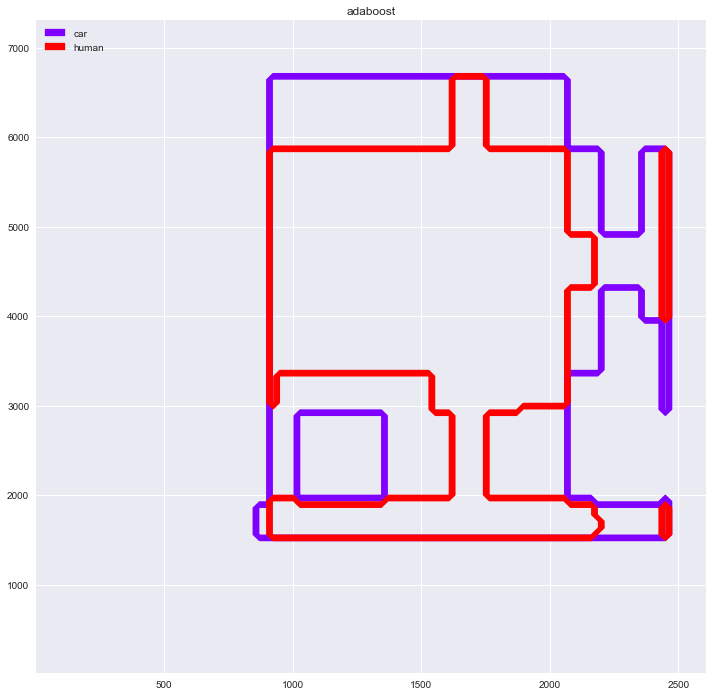

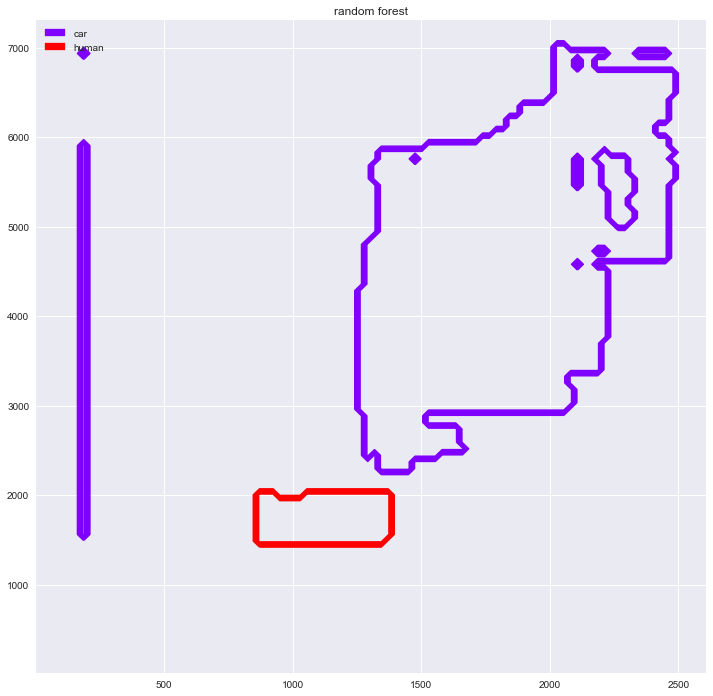

In [57]:
classifiers = [
    neural_network.MLPClassifier(hidden_layer_sizes=(30,30,30)),
    ensemble.AdaBoostClassifier(n_estimators=40, learning_rate=0.9),
    ensemble.RandomForestClassifier()
]

titles = (
    'perceptron',
    'adaboost',
    'random forest'
)

for clf, title in zip(classifiers, titles):
    detector.plot_decision_boundaries(clf, title)


In [56]:
score= np.zeros((100,10))
for i in range(1,100):
    for j in [x * 0.1 for x in range(1, 10)]:
        score[i][int(j*10)]=detector.classify(ensemble.AdaBoostClassifier(n_estimators=i, learning_rate=j))[3]
#test best (n_estimators,learning_rate) comination
a,b= np.unravel_index(np.argmax(score, axis=None),score.shape)
print("Accuracy=" +str(score[a][b])+ "for n_estimators=" + str(a)+"for learning rate="+str((b+1)/10) ) 

Accuracy=0.9506134969325153for n_estimators=40for learning rate=0.9


In [13]:
print(detector.classify(neural_network.MLPClassifier(activation='tanh',max_iter=600,verbose=False)))

(array([[2771,   12],
       [ 176,  301]]), 0.20380282402038574, MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=600, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False), 0.9423312883435583)
